###  Content Analysis News Media Outlets- Inmigration Posts

### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("FB_groups_News_Media_Outlets_immigration.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(451, 38)

In [5]:
posts['URL']

0      https://www.facebook.com/wearemitu/posts/27888...
1      https://www.facebook.com/hiplatinas/posts/2890...
2      https://www.facebook.com/NBCLatino/posts/34952...
3      https://www.facebook.com/NBCLatino/posts/35251...
4      https://www.facebook.com/Remezcla/posts/101589...
                             ...                        
446    https://www.facebook.com/ReflejosNewspaper/pos...
447    https://www.facebook.com/BDNnews1/posts/338546...
448    https://www.facebook.com/fusiontv/posts/161950...
449    https://www.facebook.com/lavozhouston/posts/34...
450    https://www.facebook.com/LatinTrends/posts/380...
Name: URL, Length: 451, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [6]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [7]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'Overperforming Score', 'clean_url', 'State', 'Facebook',
       'MessageDescr', 'MessageOnly'],
      dtype='object')

In [8]:
posts["Created"].head(5)

0    2020-10-05 21:00:11 EDT
1    2020-09-18 09:53:54 EDT
2    2020-10-20 18:46:30 EDT
3    2020-10-31 17:49:32 EDT
4    2020-09-12 21:40:01 EDT
Name: Created, dtype: object

In [9]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0     2020-10-05 21:00:11-04:00
1     2020-09-18 09:53:54-04:00
2     2020-10-20 18:46:30-04:00
3     2020-10-31 17:49:32-04:00
4     2020-09-12 21:40:01-04:00
                 ...           
446   2020-10-16 16:50:26-04:00
447   2020-10-20 10:02:09-04:00
448   2020-10-22 18:02:15-04:00
449   2020-10-20 12:00:52-04:00
450   2020-11-03 13:57:13-05:00
Name: converted_date, Length: 451, dtype: datetime64[ns, tzlocal()]

In [10]:
posts['converted_date'] = posts['converted_date'].dt.date
posts['converted_date'] 

0      2020-10-05
1      2020-09-18
2      2020-10-20
3      2020-10-31
4      2020-09-12
          ...    
446    2020-10-16
447    2020-10-20
448    2020-10-22
449    2020-10-20
450    2020-11-03
Name: converted_date, Length: 451, dtype: object

In [11]:
import seaborn as sns
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date.sort_values(by='count',ascending=False)

,converted_date,count
30,2020-09-17,14
34,2020-09-21,12
66,2020-10-23,12
28,2020-09-15,12
27,2020-09-14,11
...,...,...
61,2020-10-18,1
6,2020-08-24,1
33,2020-09-20,1
45,2020-10-02,1


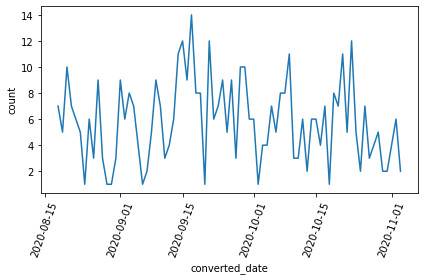

In [12]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [13]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Sponsor Name,Total Interactions,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x ),Overperforming Score,clean_url,State,Facebook,MessageDescr,MessageOnly,converted_date
75,185501,NY1 Noticias,NY1Noticias,9.183935e+10,65768.0,2020-09-26 20:30:11 EDT,Link,61,3,18,...,NaN,106,106,1.32,ny1noticias,New York,https://www.facebook.com/NY1Noticias/,"""No importa en qué llegas, en avión, en carro,...","""No importa en qué llegas, en avión, en carro,...",2020-09-26


In [14]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [15]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [16]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

##  Count posts in general by state

In [17]:

df_count = posts.groupby(['State']).agg({'Facebook Id':'count'}).reset_index() 

df_count.columns = ['State','Posts_Counts']
df_count.sort_values(by=['State'], ascending=True,inplace=True)
df_count.fillna(0, inplace=True)
df_count['Posts_Counts'] = df_count['Posts_Counts'].astype(int)
df_count.head(10)



,State,Posts_Counts
0,Alabama,1
1,Arizona,6
2,California,71
3,Colorado,13
4,Connecticut,3
5,Delaware,1
6,District of Columbia,2
7,Florida,19
8,Georgia,3
9,Idaho,1


In [18]:
#us_states['State'] = us_states['State']
from functools import reduce
data_frames = [df_count, us_states]
missing_states  = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
missing_states.fillna(0, inplace=True)
missing_states['Posts_Counts'] = missing_states['Posts_Counts'].astype(int)
missing_states

,State,Posts_Counts
0,Alabama,1
1,Arizona,6
2,California,71
3,Colorado,13
4,Connecticut,3
5,Delaware,1
6,District of Columbia,2
7,Florida,19
8,Georgia,3
9,Idaho,1


## 3. Which groups are publishing the majority of the content

In [19]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
Al DA News Media,51
We are mit,39
NOTICIAS DMV,33
Hola America,32
Remezcla,21
...,...
MiamiDiario,1
Miniondas Newspaper,1
Neta,1


In [20]:


republicans = "donald trump|trump|mike pence|nikki haley|john mccain|susan collins|rand paul|chris christie|\
jeff flake|roger stone|george bush|george w. bush|herbert hoover|charles curtis|sarah palin|bill weld|\
rocky de la fuente|joe walsh|mark sanford|herman cain|brad parscale|melania trump|richard nixon|jared kushner|\
ivanka trump|lindsey graham|newt gingrich|rudy giuliani|william barr|mitch mcconnell|gop|republican|\
republicans|republicano|republicanos"


#democrats
democrats = 'joe biden|biden|hillary clinton|kamala harris|michelle obama|bernie sanders|andrew cuomo|tom pérez|\
harry reid|bill clinton|barack obama|adlai stevenson ii|pete buttigieg|michael bennet|deval patrick|andrew yang|\
amy klobuchar|tom steyer|michael bloomberg|elizabeth warren|tulsi gabbard|geraldine ferraro|tony evers|\
nancy pelosi|josh shapiro|democrat|democrats|democratas|democrata'


general_politics = "kanye west|jo jorgensen|spike cohen|howie hawkins|angela walker|don blankenship|gloria la riva|\
brian t. carroll|brock pierce|phil collins|bill hammons|jerome segal|blake huber|mark charles|dario hunter|\
joseph kishore|alyson kennedy|jade simmons|joe mchugh|kyle kopitke|amy coney barrett|ruth bader ginsburg|\
george floyd|oprah winfrey|breonna taylor|geng shuang|philip goldberg|jho low|chris krebs|chris wallace|\
christopher a. wray|louis dejoy|merrick garland|steve scully|susan page|kristen welker|urszula gacek|\
michael georg link|william h. frey|ann selzer|samuel alito|tucker carlson|cynthia stephens|sidney powell|\
shelby pierson|joseph maguire"



posts_democrats = posts.copy()
posts_democrats = posts[posts['MessageDescr'].str.lower().str.contains(democrats   ,na = False)]
print('democrats', posts_democrats.shape)

posts_republicans = posts.copy()
posts_republicans = posts[posts['MessageDescr'].str.lower().str.contains(republicans   ,na = False)]
print('republicans', posts_republicans.shape)

posts_general_politics = posts.copy()
posts_general_politics = posts[posts['MessageDescr'].str.lower().str.contains(general_politics   ,na = False)]
print('general politics', posts_general_politics.shape)


posts_none = posts.copy()
posts_none = posts[~posts['MessageDescr'].str.lower().str.contains(general_politics + '|' + democrats + '|' +republicans ,na = False)]
print('none',posts_none['MessageDescr'].shape)

posts['Link Text'].isna().sum()

democrats (35, 39)
republicans (86, 39)
general politics (2, 39)
none (348,)


57

### 6.Filter Posts per each political party
How much each candidate talked about all the topics that Latinx cared about

In [21]:
posts_democrats['MessageDescr'][3:6]

20    Trump’s immigration adviser Stephen Miller has...
24    Trump mocks some undocumented immigrants as ha...
39    U.S. President Donald Trump visited Yuma Tuesd...
Name: MessageDescr, dtype: object

In [22]:
posts_democrats.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'Overperforming Score', 'clean_url', 'State', 'Facebook',
       'MessageDescr', 'MessageOnly', 'converted_date'],
      dtype='object')

In [23]:
df_dem = posts_democrats['State'].value_counts().reset_index()
df_dem.columns = ['State','Count']

In [24]:
df_rep = posts_republicans['State'].value_counts().reset_index()
df_rep.columns = ['State','Count']

In [25]:
df_gen_pol = posts_general_politics['State'].value_counts().reset_index()
df_gen_pol.columns = ['State','Count']

In [26]:
df_gen_info = posts_none['State'].value_counts().reset_index()
df_gen_info.columns = ['State','Count']

In [27]:
from functools import reduce
data_frames = [df_dem, df_rep,df_gen_pol,df_gen_info]
df_all = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
df_all.columns = ['State','Posts_Dem','Posts_Rep', 'Posts_Gen_Pol','Post_Gen_Info']
df_all.sort_values(by=['State'], ascending=True,inplace=True)
df_all.fillna(0, inplace=True)
df_all['Posts_Dem'] = df_all['Posts_Dem'].astype(int)
df_all['Posts_Rep'] = df_all['Posts_Rep'].astype(int)
df_all['Posts_Gen_Pol'] = df_all['Posts_Gen_Pol'].astype(int)
df_all['Post_Gen_Info'] = df_all['Post_Gen_Info'].astype(int)
df_all

,State,Posts_Dem,Posts_Rep,Posts_Gen_Pol,Post_Gen_Info
7,Alabama,1,1,0,0
5,Arizona,1,1,0,5
2,California,5,23,0,45
13,Colorado,0,2,0,11
22,Connecticut,0,0,0,3
30,Delaware,0,0,0,1
26,District of Columbia,0,0,0,2
9,Florida,1,7,0,12
23,Georgia,0,0,0,3
15,Idaho,0,1,0,0


In [28]:
dummy = posts_democrats[posts_democrats['MessageDescr'].str.contains("gop")]
pd.set_option('display.max_colwidth', 400)
dummy['MessageDescr']

Series([], Name: MessageDescr, dtype: object)

## FB Groups Political Posts

In [29]:
posts_political =  pd.concat([posts_democrats,posts_republicans,posts_general_politics])

#posts_political = df_posts_state[df_posts_state['MessageDescr'].str.lower().str.contains(democrats + '|' +republicans+ '|' +general_politics, na = False)]
df_political = posts_political['State'].value_counts().reset_index()
df_political.columns = ['State','Count']
df_political

,State,Count
0,New York,36
1,California,28
2,Pennsylvania,20
3,Florida,8
4,Wisconsin,4
5,Iowa,4
6,Massachusetts,3
7,Illinois,3
8,Colorado,2
9,Oklahoma,2


## Tokenize words and Clean-up text

In [30]:
content = posts.copy()
content['MessageDescr']

0      He has also released a plan that would fully reinstate DACA and work on legislation to offer a pathway to citizenship. #na Presidential candidate Joe Biden reminded his supporters that he intends to freeze deportations during the first 100 days to reform the immigration system. Joe Biden Promises To Freeze Deportations During His First 100 Days If Elected https://wearemitu.com/things-that-matt...
1      #Repost @alex.albadree ・・・ Nurse Wooten’s Bravery Should Be Uplifted Now!!          Nurse Dawn Wooten shows us what courage looks like. Her bravery should be uplifted by all Americans for exposing the Trump camp horrors.          Share her story and donate to her GoFund me Campaign.          Wooten worked at an Immigration and Customs Enforcement facility, filed a whistleblower complaint with ...
2      BREAKING: Lawyers appointed by federal judge to identify migrant families who were separated by the Trump admin. say they have yet to track down the parents of 545 children, a cou

In [31]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(451,)

In [32]:
# Convert to list
data = content.cleanMessage.tolist()

In [33]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [34]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['he', 'has', 'also', 'released', 'plan', 'that', 'would', 'fully', 'reinstate', 'daca', 'and', 'work', 'on', 'legislation', 'to', 'offer', 'pathway', 'to', 'citizenship', 'na', 'presidential', 'candidate', 'joe', 'biden', 'reminded', 'his', 'supporters', 'that', 'he', 'intends', 'to', 'freeze', 'deportations', 'during', 'the', 'first', 'days', 'to', 'reform', 'the', 'immigration', 'system', 'joe', 'biden', 'promises', 'to', 'freeze', 'deportations', 'during', 'his', 'first', 'days', 'if', 'elected'], ['repost', 'alex', 'albadree', 'nurse', 'wooten', 'bravery', 'should', 'be', 'uplifted', 'now', 'nurse', 'dawn', 'wooten', 'shows', 'us', 'what', 'courage', 'looks', 'like', 'her', 'bravery', 'should', 'be', 'uplifted', 'by', 'all', 'americans', 'for', 'exposing', 'the', 'trump', 'camp', 'horrors', 'share', 'her', 'story', 'and', 'donate', 'to', 'her', 'gofund', 'me', 'campaign', 'wooten', 'worked', 'at', 'an', 'immigration', 'and', 'customs', 'enforcement', 'facility', 'filed', 'whistle

#### Creating Bigram and Trigram Models

In [35]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['he', 'has', 'also', 'released', 'plan', 'that', 'would', 'fully', 'reinstate', 'daca', 'and', 'work', 'on', 'legislation', 'to', 'offer', 'pathway', 'to', 'citizenship', 'na', 'presidential', 'candidate', 'joe_biden', 'reminded', 'his', 'supporters', 'that', 'he', 'intends', 'to', 'freeze', 'deportations', 'during', 'the', 'first', 'days', 'to', 'reform', 'the', 'immigration', 'system', 'joe_biden', 'promises', 'to', 'freeze', 'deportations', 'during', 'his', 'first', 'days', 'if', 'elected']


## Remove Stopwords, Make Bigrams and Lemmatize

In [36]:
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [37]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [38]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download es_core_news_sm
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [39]:
print(data_words_nostops[1:2])

[['repost', 'alex', 'albadree', 'nurse', 'wooten', 'bravery', 'uplifted', 'nurse', 'dawn', 'wooten', 'shows', 'us', 'courage', 'looks', 'bravery', 'uplifted', 'americans', 'exposing', 'trump', 'camp', 'horrors', 'share', 'story', 'donate', 'gofund', 'campaign', 'wooten', 'worked', 'immigration', 'customs', 'enforcement', 'facility', 'filed', 'whistleblower', 'complaint', 'department', 'homeland', 'security', 'inspector', 'general', 'dawn', 'wooten', 'licensed', 'practical', 'nurse', 'bravely', 'came', 'forward', 'alert', 'american', 'atrocities', 'committed', 'ice', 'nurse', 'irwin', 'county', 'detention', 'center', 'bravely', 'coming', 'forward', 'wooten', 'prompted', 'calls', 'federal', 'investigation', 'claims', 'immigration', 'customs', 'enforcement', 'detention', 'center', 'worked', 'performing', 'mass', 'hysterectomies', 'wooten', 'stated', 'complaint', 'everybody', 'uterus', 'cannot', 'bad', 'moreover', 'wooten', 'said', 'hispanics', 'treated', 'worst', 'facility', 'dawnwooten',

## Bag of Words

In [40]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [41]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [42]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [43]:
final_dict.most_common(1000)

[('legal', 54),
 ('inmigrante', 54),
 ('trump', 47),
 ('abogar', 43),
 ('immigration', 40),
 ('necesitar', 32),
 ('mexico', 30),
 ('preguntar', 30),
 ('familia', 29),
 ('daca', 26),
 ('unir', 26),
 ('hola_america', 26),
 ('personar', 24),
 ('migratorio', 23),
 ('nuevo', 22),
 ('ayudar', 20),
 ('derecho', 20),
 ('also', 19),
 ('programar', 19),
 ('decir', 19),
 ('ciudad', 19),
 ('latino', 18),
 ('federal', 18),
 ('inmigracion', 18),
 ('historia', 18),
 ('oficina', 18),
 ('covid / coronavirus', 18),
 ('hijo', 17),
 ('nurse', 16),
 ('ano', 16),
 ('local', 16),
 ('reform', 15),
 ('hacer', 15),
 ('centrar', 15),
 ('border', 14),
 ('migrante', 14),
 ('grupo', 14),
 ('indicar', 14),
 ('canada', 14),
 ('states', 13),
 ('preparar', 13),
 ('placer', 13),
 ('cultural', 13),
 ('hablar', 13),
 ('poder', 13),
 ('espanol', 13),
 ('votar', 12),
 ('anunciar', 12),
 ('acompananos', 12),
 ('partir', 12),
 ('familiar', 12),
 ('mayoria', 12),
 ('comercial', 12),
 ('profesional', 12),
 ('cliente', 12),
 ('r

In [44]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [45]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
print(bow_df)

     aaron  abajar  able  abogar  abolimiento  abolir  abolishice  \
0        0       0     0       0            0       0           0   
1        0       0     0       0            0       0           1   
2        0       0     0       0            0       0           0   
3        0       0     0       0            0       0           0   
4        0       0     0       0            0       0           0   
..     ...     ...   ...     ...          ...     ...         ...   
446      0       0     0       0            0       0           0   
447      0       0     0       0            0       0           0   
448      0       0     0       0            0       0           0   
449      0       0     0       0            0       0           0   
450      0       0     0       0            0       0           0   

     abolishpolice  abrio  abrir  ...  votar  votolatino  vountarios  \
0                0      0      0  ...      0           0           0   
1                1      0  

In [46]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [47]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
legal,3.307020
immigration,3.424803
abogar,3.502764
trump,3.617175
necesitar,3.617175
...,...
extraordinario,6.420535
extra,6.420535
extinguir,6.420535
failures,6.420535


In [48]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [49]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [50]:
df

,tfidf
candidate,0.422480
na,0.347859
presidential,0.354890
promises,0.473609
reform,0.354890
reminded,0.473609


In [51]:
word = df.index[1]
content["lowercase"] = content['cleanMessage'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word + "_messages.csv")
word_messages

,unique_messages,counts
0,"durante más de una década, la oficina legal del abogado luis paoli, ha estado tratando casos de inmigración para muchas personas en el área del norte de virginia, obteniendo muy buenos resultados. si necesitas una cita personalizada llámanos hoy al (703) 914-0046 paoli law",10
1,"¿necesitas asesoría legal para un familiar con problema de inmigración? contáctanos ahora, una llamada podría significar mucho en este momento. (703) 914-0046 paoli law paoli law",6
2,#abogadohouston #abogadoinmigracion #inmigracion #latinosinmigrantes #visas #oficinalegal #lawyersofinstagram #daca #tps #preguntas #immigration #deportaciones #greencard #ciudadania #residencia #peticiones #detenciones #socialmediacampaign #latinosinmigrantes #tarjetaverde #inmigracion,6
3,"advocates aid immigrant families with schools reopening keep on it. as the city’s public schools prepare to reopen, advocates are urging immigrant families to stay on top of the latest information on reopening plans. “we have to, as a city right now, make all the right preparations to ensure that everyone’s health and safety and educational progress at school happens,” said kim sykes, director...",5
4,"advocates aid immigrant families with schools reopening keep on it. as the city’s public schools prepare to reopen, advocates are urging immigrant families to stay on top of the latest information on reopening plans. “we have to, as a city right now, make all the right preparations to ensure that everyone’s health and safety and educational progress at school happens,” said kim sykes, director...",5
...,...,...
212,"the 2020 presidential election will pit two drastically different visions on immigration against each other, with the victor retaining or assuming broad executive authorities that have dominated policy-making on the issue for decades in the absence of congressional action via cbs news biden has pledged to dismantle the president's restrictive immigration policies. but former dhs officials say ...",1
213,"marchers get vocal as they prepare to take to the streets of st. louis in a abolish ice march in st. louis on saturday, september 19, 2020. the group is asking for the abolishment of the u.s. immigration and customs enforcement agency, saying that deportation is a crime. photo by bill greenblatt/upi 😯😯😯😯😯😯😯😯 los marchistas se ponen vocales mientras se preparan para tomar las calles de st. loui...",1
214,"today is national immigrants day, and today we honor, highlight, and celebrate the lives, work, contributions, and impact of immigrants in our neighborhoods, cities, state, and country. la casa de amistad has and will continue to advocate for immigrants through our programs and by being a voice for immigrants. our citizenship program has a long history of success and has so far graduated and ...",1
215,"these l.a. institutions have been accepting money from an organization that has also funded ‘anti-immigration’ and ‘extremist hate groups’ since the year 2000, the foundation has donated millions of dollars to the ucla foundation, l.a., the la zoo foundation, usc, l.a. opera, kcrw foundation, the l.a. natural history museum, and more. these l.a. institutions have been accepting money from an o...",1


### Repeated messages

In [52]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

results.to_csv("mostpopularNewsMedia.csv")

In [53]:
results.sort_values(by='Counts',ascending=False)

,,Counts,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Total Interactions
MessageDescr,Link,,,,,,,,,,,
"Advocates aid immigrant families with schools reopening Keep on it. As the city’s public schools prepare to reopen, advocates are urging immigrant families to stay on top of the latest information on reopening plans. “We have to, as a city right now, make all the right preparations to ensure that everyone’s health and safety and educational progress at school happens,” said Kim Sykes, Director of Education Policy for the New York Immigration Coalition (NYIC), at a virtual press briefing held on Tues., Sept. 8. “A key part of ensuring real safety and being truly prepared to open is having a system in place that… gets information to immigrant families in their home language so that they are informed as soon as other parents are informed,” she said. Sykes said the launch of remote school orientations on September 16 would be essential for helping students to reconnect with teachers while reviewing school procedures as well as safety protocols. However, she cautioned that many immigrant families have reported not having technology to begin remote learning. “We’re encouraging families to fill out a device request form that is online and also to contact their school,” she said. “We’re encouraging them to do this now so they can get the device for September 16.” Continúen. Mientras las escuelas públicas de la ciudad se preparan para reabrir, los defensores instan a las familias inmigrantes a mantenerse al tanto de la información más reciente sobre los planes de reapertura. “They are not alone”""No están solos"" - The Bronx Free Press https://thebronxfreepress.com/they-are-not-aloneno-estan-solos/",https://thebronxfreepress.com/they-are-not-aloneno-estan-solos/,5,3,0,0,0,0,0,0,0,0,3
"Advocates aid immigrant families with schools reopening Keep on it. As the city’s public schools prepare to reopen, advocates are urging immigrant families to stay on top of the latest information on reopening plans. “We have to, as a city right now, make all the right preparations to ensure that everyone’s health and safety and educational progress at school happens,” said Kim Sykes, Director of Education Policy for the New York Immigration Coalition (NYIC), at a virtual press briefing held on Tues., Sept. 8. “A key part of ensuring real safety and being truly prepared to open is having a system in place that… gets information to immigrant families in their home language so that they are informed as soon as other parents are informed,” she said. Sykes said the launch of remote school orientations on September 16 would be essential for helping students to reconnect with teachers while reviewing school procedures as well as safety protocols. However, she cautioned that many immigrant families have reported not having technology to begin remote learning. “We’re encouraging families to fill out a device request form that is online and also to contact their school,” she said. “We’re encouraging them to do this now so they can get the device for September 16.” Continúen. Mientras las escuelas públicas de la ciudad se preparan para reabrir, los defensores instan a las familias inmigrantes a mantenerse al tanto de la información más reciente sobre los planes de reapertura. “They are not alone”""No están solos"" - Manhattan Times News https://www.manhattantimesnews.com/they-are-not-aloneno-estan-solos/",https://www.manhattantimesnews.com/they-are-not-aloneno-estan-solos/,5,7,0,0,0,0,0,0,0,0,7
¿Necesitas representación legal ? Somos especialistas en casos de inmigración. Llámanos ahora para una asesoría personalizada (703) - 914-0046 Paoli Law Paoli Law https://www.facebook.com/PaoliLawImmigration/videos/574169060048445/,https://www.facebook.com/PaoliLawImmigration/videos/574169060048445/,4,15,0,0,1,0,0,0,0,0,16
"The reflection of the mistreatment in ICE custody keeps unveiling itself to the public. If anyone running ICE detention centers has not noticed, t

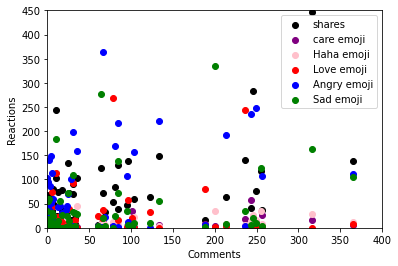

In [54]:
results.reset_index()
plt.xlim(0,400)
plt.ylim(0,450)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


In [55]:
#Topic Modeling
#Create the Dictionary and Corpus needed for Topic Modeling


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]
[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]
#Buiding the Topic Model



[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]

In [56]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [57]:
#View the topics in LDA model
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.077*"defensa" + 0.064*"centrar" + 0.059*"programar" + 0.049*"ano" + '
  '0.039*"casar" + 0.030*"local" + 0.027*"permitir" + 0.024*"georgia" + '
  '0.023*"condado" + 0.023*"hombre"'),
 (1,
  '0.128*"latino" + 0.066*"sexual" + 0.053*"america" + 0.053*"especially" + '
  '0.027*"physical" + 0.020*"importante" + 0.018*"look" + 0.011*"critical" + '
  '0.009*"latinx" + 0.006*"hunger"'),
 (2,
  '0.108*"votar" + 0.067*"donald_trump" + 0.037*"year" + 0.037*"theme" + '
  '0.017*"pocho" + 0.017*"seen" + 0.013*"closer" + 0.012*"able" + 0.009*"post" '
  '+ 0.007*"arrests"'),
 (3,
  '0.066*"honor" + 0.033*"serie" + 0.016*"arrived" + 0.010*"born" + '
  '0.010*"netflix" + 0.001*"august" + 0.001*"cesar_lopez" + 0.001*"oral" + '
  '0.001*"cultural" + 0.001*"crear"'),
 (4,
  '0.043*"experiences" + 0.041*"medical" + 0.026*"rules" + '
  '0.009*"asylum_seekers" + 0.009*"prices" + 0.009*"established" + '
  '0.009*"raised" + 0.009*"tackle" + 0.009*"dangerous" + 0.005*"meeting"'),
 (5,
  '0.112*"ayuda

In [58]:
#Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.128876245516274

Coherence Score:  0.4066116215295395


In [59]:
#Visualize the topics-keywords
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.378166 -0.000310       1        1  25.528744
0     -0.080010  0.123553       2        1  12.629123
5     -0.000525 -0.219734       3        1  12.388673
19    -0.004197 -0.190280       4        1  10.766388
13     0.038060  0.035997       5        1   5.126113
18     0.025689  0.019033       6        1   3.826297
1      0.027126  0.013960       7        1   3.801253
6      0.033249  0.022622       8        1   3.259421
7      0.033040  0.020338       9        1   3.098944
8      0.029125  0.031940      10        1   3.086387
2      0.024160  0.017520      11        1   2.622630
16     0.031300  0.017828      12        1   2.576052
10     0.041050  0.022726      13        1   2.494570
12     0.035044  0.021836      14        1   1.775744
17     0.026259  0.014735      15        1   1.581896
14     0.024101  0.009668      16        1   1.320421
4      0.024669  0.010139      17        1   1.261834
3      0.022982  0.008868      18        1   1.248736
15     0.028749  0.014470      19        1   1.117018
11     0.018295  0.005089      20        1   0.489756, topic_info=               Term        Freq       Total Category  logprob  loglift
48            legal   88.000000   88.000000  Default  30.0000  30.0000
20            trump   51.000000   51.000000  Default  29.0000  29.0000
96           abogar   98.000000   98.000000  Default  28.0000  28.0000
13      immigration   46.000000   46.000000  Default  27.0000  27.0000
167      inmigrante  174.000000  174.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
568      celebrates    0.014333    1.204608  Topic20  -7.4579   0.8877
569   loscenzontles    0.014333    1.204608  Topic20  -7.4579   0.8877
570         musical    0.014333    1.204608  Topic20  -7.4579   0.8877
555        mexicano    0.014333    1.204640  Topic20  -7.4579   0.8876
1676           fear    0.014333    1.204682  Topic20  -7.4579   0.8876

[766 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
218       4  0.460457           9
109      11  0.723640        able
96        3  0.121323      abogar
96        4  0.869480      abogar
6         9  0.583263  abolishice
...     ...       ...         ...
199       1  0.940686        vida
179       2  0.463064       vivir
179      10  0.463064       vivir
116      11  0.904861       votar
51       11  0.814329        year

[301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 6, 20, 14, 19, 2, 7, 8, 9, 3, 17, 11, 13, 18, 15, 5, 4, 16, 12])

## Building LDA Mallet Model

In [60]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [61]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('decir', 0.06844106463878327),
   ('grupo', 0.03802281368821293),
   ('importante', 0.03802281368821293),
   ('sabado', 0.034220532319391636),
   ('septiembre', 0.034220532319391636),
   ('publicar', 0.030418250950570342),
   ('mes', 0.026615969581749048),
   ('hombre', 0.026615969581749048),
   ('manifestante', 0.022813688212927757),
   ('nacional', 0.019011406844106463)]),
 (7,
  [('trump', 0.1729957805907173),
   ('abogar', 0.10548523206751055),
   ('preparar', 0.05485232067510549),
   ('acompananos', 0.05063291139240506),
   ('junto', 0.04219409282700422),
   ('law', 0.02531645569620253),
   ('hablar', 0.02531645569620253),
   ('live', 0.02531645569620253),
   ('impactar', 0.02531645569620253),
   ('esperar', 0.02531645569620253)]),
 (11,
  [('migratorio', 0.09523809523809523),
   ('virtual', 0.047619047619047616),
   ('debatir', 0.04285714285714286),
   ('presidential', 0.04285714285714286),
   ('politica', 0.0380952380952381),
   ('final', 0.0380952380952381),
   ('na', 

## Finding the optimal number of topics for LDA

In [62]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [63]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

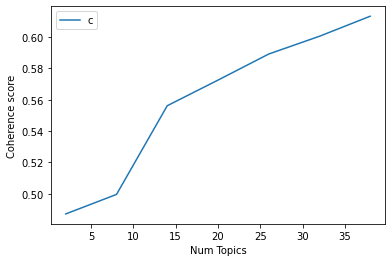

In [64]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [65]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4872
Num Topics = 8  has Coherence Value of 0.4996
Num Topics = 14  has Coherence Value of 0.5561
Num Topics = 20  has Coherence Value of 0.5724
Num Topics = 26  has Coherence Value of 0.5891
Num Topics = 32  has Coherence Value of 0.6004
Num Topics = 38  has Coherence Value of 0.6131


In [66]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.040*"historia" + 0.031*"latino" + 0.029*"cultural" + 0.027*"oral" + '
  '0.022*"estudiante" + 0.020*"crear" + 0.020*"informar" + 0.020*"formar" + '
  '0.020*"personal" + 0.018*"estatus"'),
 (1,
  '0.063*"unir" + 0.053*"nuevo" + 0.046*"programar" + 0.041*"hijo" + '
  '0.027*"solicitud" + 0.027*"ano" + 0.024*"padre" + 0.022*"miembro" + '
  '0.022*"estadounidense" + 0.019*"presentar"'),
 (2,
  '0.064*"migratorio" + 0.044*"local" + 0.039*"migrante" + 0.033*"federal" + '
  '0.033*"inmigrante" + 0.028*"carga_publica" + 0.028*"virtual" + 0.025*"http" '
  '+ 0.025*"servicio" + 0.022*"indocumentado"'),
 (3,
  '0.051*"reform" + 0.034*"na" + 0.031*"debatir" + 0.031*"presidential" + '
  '0.031*"country" + 0.031*"national" + 0.020*"medical" + 0.020*"permanente" + '
  '0.017*"bueno" + 0.017*"clear"'),
 (4,
  '0.109*"immigration" + 0.103*"abogar" + 0.065*"inmigrante" + 0.054*"derecho" '
  '+ 0.035*"espanol" + 0.033*"mayoria" + 0.030*"defensa" + 0.030*"firmar" + '
  '0.027*"escribir" + 0.027

## Finding the dominant topic in each sentence

In [67]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1293,"reform, na, debatir, presidential, country, national, medical, permanente, bueno, clear",He has also released a plan that would fully reinstate DACA and work on legislation to offer a pathway to citizenship. #na Presidential candidate Joe Biden reminded his supporters that he intends to freeze deportations during the first 100 days to reform the immigration system. Joe Biden Promises To Freeze Deportations During His First 100 Days If Elected
1,1,8.0,0.1538,"coronavirus, nurse, border, states, sabado, septiembre, pandemic, made, issue, amid","#Repost @alex.albadree ・・・ Nurse Wooten’s Bravery Should Be Uplifted Now!! Nurse Dawn Wooten shows us what courage looks like. Her bravery should be uplifted by all Americans for exposing the Trump camp horrors. Share her story and donate to her GoFund me Campaign. Wooten worked at an Immigration and Customs Enforcement facility, filed a whistleblower complaint with the Department of Homeland ..."
2,2,13.0,0.0896,"trump, preguntar, inmigracion, preparar, acompananos, law, vivir, junto, hablar, dudar","BREAKING: Lawyers appointed by federal judge to identify migrant families who were separated by the Trump admin. say they have yet to track down the parents of 545 children, a court filing shows; many were deported."
3,3,8.0,0.1152,"coronavirus, nurse, border, states, sabado, septiembre, pandemic, made, issue, amid","Shakira, a Grammy-winning singer and activist, is publicly slamming the United States for ""unimaginably cruel immigration policies"" that have resulted in the separation of thousands of children from their families at the southern border. ""The unspeakable tragedy taking place at America’s southern border is about hate and the denial of basic human rights,"" the singer writes in an open letter. S..."
4,4,13.0,0.1013,"trump, preguntar, inmigracion, preparar, acompananos, law, vivir, junto, hablar, dudar","These regulations (which extend to 26 protected categories) apply in all public spaces. Finally, xenophobic discrimination based on immigration status or national origin is punishable under the law in New York. Calling Someone an “Illegal Alien” Can Lead to a $250K Fine in the State of NY"
5,5,2.0,0.0993,"migratorio, local, migrante, federal, inmigrante, carga_publica, virtual, http, servicio, indocumentado","White supremacy was behind child separations — and Trump officials went along, critics say. An NBC News report that White House senior adviser Stephen Miller asked top administration officials and cabinet members to raise their hands and approve child separations— because not enforcing strict immigration policy would be ""the end of our country as we know it""—is a ""damning display of white supr..."
6,6,3.0,0.1336,"reform, na, debatir, presidential, country, national, medical, permanente, bueno, clear","The battle over immigration policy is far from over but it is clear that the Trump administration is on the wrong side of public opinion. Luckily, Presidential nominee Joe Biden has a plan to change things for the better. #YoBidenYtu #TodosConBiden #sponsored During the latest debate, Joe Biden went on the offensive against Trumps family separation policy and outlined his vision for the best w..."
7,7,5.0,0.0875,"decir, pasar, general, votar, policia, elección, publicar, hombre, hora, sexual","Do you think Melania and Michelle are held to different standards? #ra Photo: Alex Wong/Getty Images It looks like the Melania Trump isnt quite as stoic as everyone thinks she is. The First Lady was caught on tape discussing immigration policy, her negative news media coverage and...Christmas decorations. The audio recording was captured by Mrs. Trumps former Melania Trump Caught on Tape Discu..."
8,8,8.0,0.0879,"coronavirus, nurse, border, states, sabado, septiembre, pandemic, made, issue, amid","Trump cabinet officials voted in 2018 White House meeting to separate migrant children, officials say. ""If we d

## Find the most representative document for each topic


In [71]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6800,"historia, latino, cultural, oral, estudiante, crear, informar, formar, personal, estatus","¡No olviden registrarse y acompañarnos! Don’t miss this event! PerformancerUS will be presenting, Performing Ourselves, Performing our Histories, a series of poems, monologues, and dialogues inspired by the Oral Narratives of Latin@ in Ohio (ONLO) archive, and each of the ensemble members personal and collective stories. This performance piece engages with the archive and finds common ground o..."
1,1.0,0.6135,"unir, nuevo, programar, hijo, solicitud, ano, padre, miembro, estadounidense, presentar","USCIS Implementa Nueva Ley Relacionada con la Ciudadanía para Hijos de Militares y Empleados del Gobierno de Estados Unidos Destacados en el Extranjero El 18 de septiembre, actualizamos nuestras guías de políticas concernientes a los requisitos de residencia bajo la sección 320 de la Ley de Inmigración y Nacionalidad (INA) para cumplir con la Ley de Ciudadanía para Hijos de Militares y Servido..."
2,2.0,0.3640,"migratorio, local, migrante, federal, inmigrante, carga_publica, virtual, http, servicio, indocumentado","Una organización ofrece ayuda migratoria virtual y completamente gratuita es lo que migrantes de todos los Estados Unidos podrán recibir gracias a los servicios de una organización no lucrativa de Allston, Massachusetts. ImmigrationHelp.org está compuesta de inmigrantes, o hijos de inmigrantes, donde ofrecen una gran variedad de servicios para las comunidades migrantes en toda la nación. Una o..."
3,3.0,0.2606,"reform, na, debatir, presidential, country, national, medical, permanente, bueno, clear","Sara Huddleston, demócrata, se postula para la elección a la Cámara de Representantes de Iowa del Distrito 11 de los condados de Buena Visa y Sac. Hello friends from La Prensa we are here in Storm Lake, IA with Mrs. Sara Huddleston. Its very difficult for me to pronounce her last name. Sara is a Latina that is running for the Iowa House of Representatives. This is the second time that Sara is ..."
4,4.0,0.3461,"immigration, abogar, inmigrante, derecho, espanol, mayoria, defensa, firmar, escribir, timeline_photos","¿Te enviaron a corte? Pues necesitas a los mejores especialistas en Defensa en Cortes de Inmigración😉.⁣⁣⁣⁣ ⁣⁣⁣⁣ Venero Law, PLLC es una firma de abogados que defiende tus derechos como inmigrante. Todos en la firma hablan español y la mayoría de los asistentes legales son venezolanos🇻🇪👌🏻.⁣⁣⁣⁣ ⁣⁣⁣⁣ Ellos podrán asesorarte, defenderte y luchar por tus derechos. Contáctalos al 512-461-4723 (llama..."
5,5.0,0.4389,"decir, pasar, general, votar, policia, elección, publicar, hombre, hora, sexual","Wisconsin.- Jacob Blake, el afroamericano de 29 años que recibió disparos de la policía en Wisconsin el mes pasado, habló desde su cama de hospital sobre el dolor de la recuperación y su esperanza en el futuro en un video publicado en Twitter por su abogado el sábado pasado. “Solo quiero decirles, hombre, a todos los ‘gatos’ jóvenes e incluso a los mayores, mayores que yo, hay mucha más vida q..."
6,6.0,0.3163,"mexico, hola_america, oficina, anunciar, virginia_obteniendo, decada, cita_personalizada, buenos_resultados, tratando_casos, conocer","Home Latest News Culture El Consulado de México anuncia la “App Denuncia Paisano” y la Tarjeta... Latest NewsCultureHola IllinoisHola IowaImmigration El Consulado de México anuncia la “App Denuncia Paisano” y la Tarjeta “Conozco mis derechos” By Hola America News - August 27, 2020 1 0 ... El Consulado de México anuncia la “App Denuncia Paisano” y la Tarjeta “Conozco mis derechos” | Hola Ameri..."
7,7.0,0.6558,"daca, personar, canada, poder, entrar, oficial, refugiar, asilar, acordar, detenido",Personas que buscan asilo continúan siendo rechazadas en la frontera Canadiense Información Incorrecta acerca de las condiciones de los cruces fronterizos expone a Migrantes. Detroit. Un número creciente de personas están viajando a la frontera estadouni

In [72]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [73]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,3.0,"reform, na, debatir, presidential, country, national, medical, permanente, bueno, clear",49.0,0.1086
1.0,8.0,"coronavirus, nurse, border, states, sabado, septiembre, pandemic, made, issue, amid",20.0,0.0443
2.0,13.0,"trump, preguntar, inmigracion, preparar, acompananos, law, vivir, junto, hablar, dudar",21.0,0.0466
3.0,8.0,"coronavirus, nurse, border, states, sabado, septiembre, pandemic, made, issue, amid",57.0,0.1264
4.0,13.0,"trump, preguntar, inmigracion, preparar, acompananos, law, vivir, junto, hablar, dudar",31.0,0.0687
5.0,2.0,"migratorio, local, migrante, federal, inmigrante, carga_publica, virtual, http, servicio, indocumentado",22.0,0.0488
6.0,3.0,"reform, na, debatir, presidential, country, national, medical, permanente, bueno, clear",34.0,0.0754
7.0,5.0,"decir, pasar, general, votar, policia, elección, publicar, hombre, hora, sexual",8.0,0.0177
8.0,8.0,"coronavirus, nurse, border, states, sabado, septiembre, pandemic, made, issue, amid",58.0,0.1286
9.0,8.0,"coronavirus, nurse, border, states, sabado, septiembre, pandemic, made, issue, amid",35.0,0.0776
